In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import keras
from keras.layers import Input, Dense
from keras.models import Model

import innvestigate
import innvestigate.utils as iutils

import numpy as np
import pandas as pd
import time
import os
import pickle

from sklearn import preprocessing
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/Users/bogao/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/bogao/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/bogao/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/bogao/anaconda3/envs/tf/l

### Load data and models

In [3]:
pklfile = '/Users/bogao/DataFiles/new landscape/data/all_bands.pkl'
with open(pklfile, 'rb') as fi:
    data = pickle.load(fi)
data = preprocessing.MinMaxScaler().fit_transform(np.abs(data))

In [4]:
def loadModel(modelpath):
    return keras.models.load_model(modelpath)

In [5]:
dae_core_1024 = loadModel('/Users/bogao/DataFiles/new landscape/models/model_dae_core_1024.mdl')

In [ ]:
dae_core_2048 = loadModel('/Users/bogao/DataFiles/new landscape/models/model_dae_core_2048.mdl')
# cae_1e07 = loadModel('/Users/bogao/DataFiles/new landscape/models/model_cae_1e-07.mdl')

In [15]:
dae_noise_0025 = loadModel('/Users/bogao/DataFiles/new landscape/models/model_dae_noise_0.025.mdl')

In [6]:
input_size = data.shape[1]
idx = 1234

### Plot check

In [11]:
def plotCheck(idx, data, model):

    plt.figure(figsize=(20,5))

    pltrows = 1
    pltcols = 2 

    plt.subplot(pltrows,pltcols, 1)
    plt.title('Original')
    sns.lineplot(x=range(input_size),y=np.abs(data[idx]))


    decoded = model.predict(data[idx].reshape(1,input_size,))
    plt.subplot(pltrows,pltcols, 2)
    plt.title('Decoded')
    sns.lineplot(x=range(input_size),y=decoded[0])


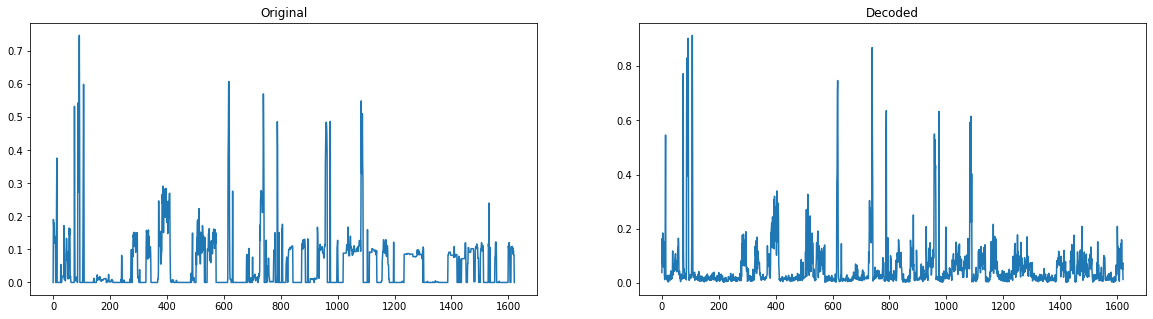

In [12]:
plotCheck(idx, data, dae_core_1024)

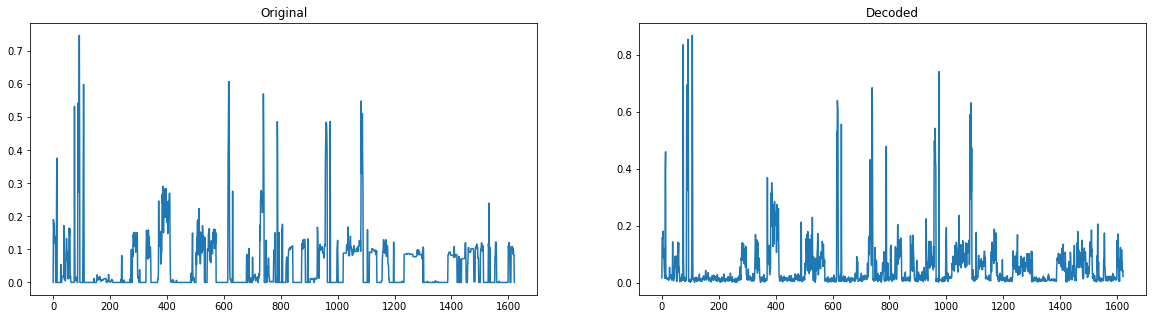

In [14]:
plotCheck(idx, data, dae_core_2048)

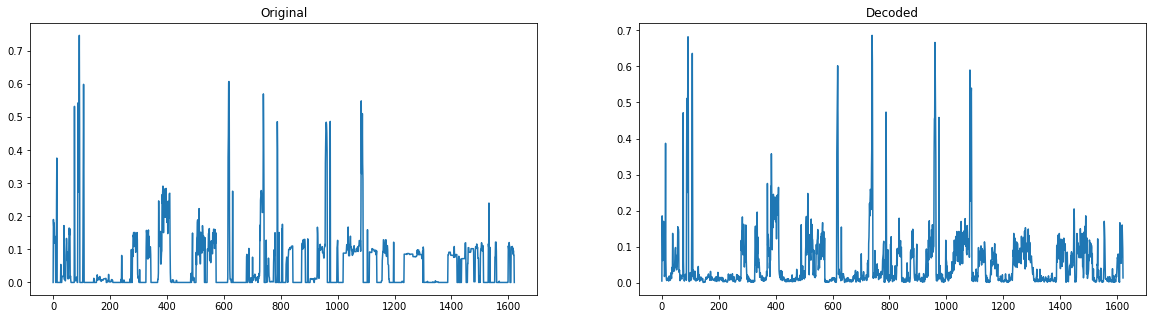

In [16]:
plotCheck(idx, data, dae_noise_0025)

### iNNvestigate

In [7]:
encoder = loadModel('/Users/bogao/DataFiles/new landscape/models/encoder_dae_core_1024.mdl')

/Users/bogao/anaconda3/envs/tf/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
x = dae_core_1024.get_layer(index=0).input
h = dae_core_1024.get_layer(index=1).output
encoder = Model(x,h)

In [ ]:
hidden_size = 1024
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", encoder, neuron_selection_mode="index")
i = 0
analysis = np.zeros(input_size)
for neuron_index in range(hidden_size):
    analysis = np.add(analysis, gradient_analyzer.analyze(data, neuron_index))
    i +=1
print(i)

#### analysis contains the summed weights from all hidden neurons

In [157]:
analysis.shape

(42820, 1622)

In [158]:
weightpkl = '/Users/bogao/DataFiles/new landscape/data/all_bands_weight.pkl'
with open(weightpkl, 'wb') as fo:
    pickle.dump(analysis, fo)

Compare with weighting

In [156]:
analysis.shape

(42820, 1622)

In [10]:
with open('/Users/bogao/DataFiles/new landscape/data/all_bands_weight.pkl', 'rb') as fi:
    analysis = pickle.load(fi)

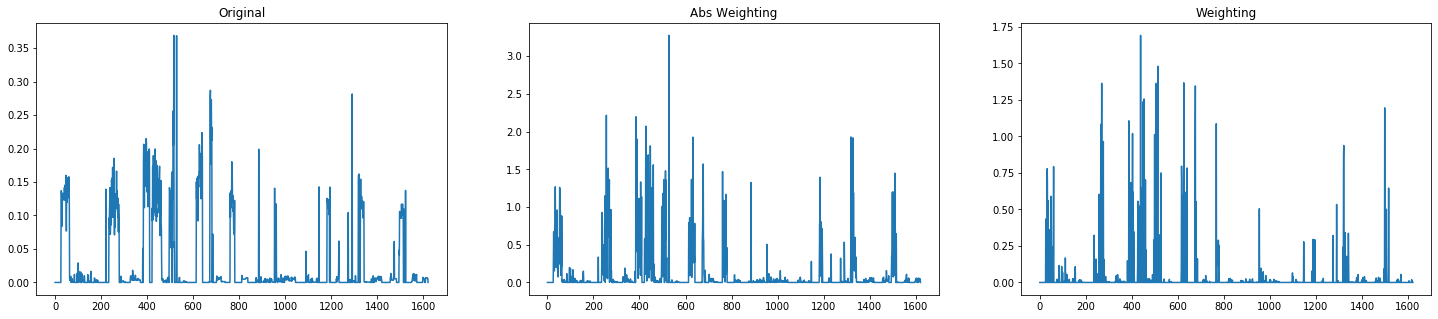

In [11]:
index = 8888
plt.figure(figsize=(25,5))
plt.subplot(1,3, 1)
plt.title('Original')
sns.lineplot(x=range(input_size),y=np.abs(data[index]))

plt.subplot(1,3, 2)
plt.title('Abs Weighting')
sns.lineplot(x=range(input_size),y=np.abs(analysis[index]))

plt.subplot(1,3, 3)
plt.title('Weighting')
sns.lineplot(x=range(input_size),y=np.maximum(analysis[index], 0))

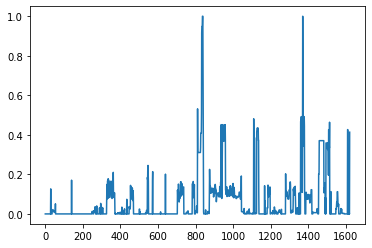

In [19]:
index = 9999
# plt.title('Original')
sns.lineplot(x=range(input_size),y=np.abs(data[index]))

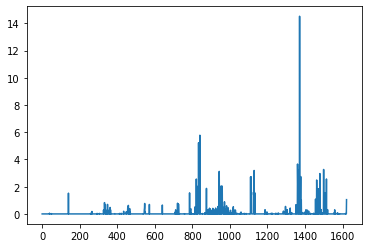

In [20]:
# plt.title('Weighting')
sns.lineplot(x=range(input_size),y=np.maximum(analysis[index], 0))

#### The band look up table

In [38]:
bandfile = '/Users/bogao/DataFiles/new landscape/data/bands.pkl'
with open(bandfile, 'rb') as fi:
    bands = pickle.load(fi)

In [29]:
bands

,chro,start,end,name,note,chr
0,chr1,0,2300000,p36.33,gneg,1
1,chr1,123400000,125100000,q11,acen,1
2,chr1,125100000,143200000,q12,gvar,1
3,chr1,143200000,147500000,q21.1,gneg,1
4,chr1,147500000,150600000,q21.2,gpos50,1
...,...,...,...,...,...,...
806,chr22,37200000,40600000,q13.1,gneg,22
807,chr22,40600000,43800000,q13.2,gpos50,22
808,chr22,43800000,48100000,q13.31,gneg,22
809,chr22,49100000,50818468,q13.33,gneg,22


In [99]:
weight = analysis[index]

In [118]:
weight[100:120]

array([-0.18508099,  0.        , -0.08300051, -0.06389166, -0.04654081,
       -0.00938904, -0.00891959, -0.03980633,  0.01202331,  0.        ,
        0.        ,  0.16795839,  0.015169  ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.0563448 ,  0.01974488, -0.01702323])

In [101]:
bands = bands.assign(dups=weight[:811])

In [102]:
bands = bands.assign(dels=weight[811:])

In [103]:
bands

,chro,start,end,name,note,chr,dups,dels
0,chr1,0,2300000,p36.33,gneg,1,0.0,0.000000
1,chr1,123400000,125100000,q11,acen,1,0.0,-0.035749
2,chr1,125100000,143200000,q12,gvar,1,0.0,-0.100470
3,chr1,143200000,147500000,q21.1,gneg,1,0.0,0.002423
4,chr1,147500000,150600000,q21.2,gpos50,1,0.0,-0.027456
...,...,...,...,...,...,...,...,...
806,chr22,37200000,40600000,q13.1,gneg,22,0.0,-0.025829
807,chr22,40600000,43800000,q13.2,gpos50,22,0.0,-0.050994
808,chr22,43800000,48100000,q13.31,gneg,22,0.0,0.009423
809,chr22,49100000,50818468,q13.33,gneg,22,0.0,-0.040452


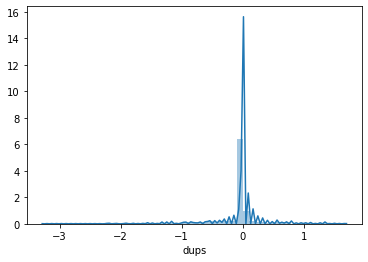

In [104]:
sns.distplot(bands['dups'])

In [105]:
dups_high = bands[bands['dups']>0.3]

In [106]:
dups_high

,chro,start,end,name,note,chr,dups,dels
26,chr1,230500000,234600000,q42.2,gpos50,1,0.434560,0.015616
32,chr1,115500000,117200000,p13.1,gneg,1,0.778689,0.000000
33,chr1,2300000,5300000,p36.32,gpos25,1,0.694620,0.000000
36,chr1,9100000,12500000,p36.22,gneg,1,0.559326,0.000000
43,chr1,32300000,34300000,p35.1,gpos25,1,0.361924,0.000000
49,chr1,111200000,115500000,p13.2,gpos50,1,0.590038,0.000000
50,chr1,46300000,50200000,p33,gpos75,1,0.580926,0.000000
60,chr1,58500000,60800000,p32.1,gneg,1,0.793157,0.000000
236,chr5,103400000,105100000,q21.2,gneg,5,0.322780,0.000000
258,chr5,4400000,6300000,p15.32,gpos25,5,0.603679,0.000000


### Gene look-up table

In [58]:
genefile = '/Users/bogao/DataFiles/Data/genome/genes.tsv'
genes = pd.read_csv(genefile,sep='\t', names=['gene_id','name','chr','start','end','symbol'], header=0)

In [107]:
high_genes = pd.merge(genes, dups_high[['name','chr','note','dups','dels']], how='inner', on=['name','chr'])

In [108]:
high_genes

,gene_id,name,chr,start,end,symbol,note,dups,dels
0,ENSG00000054523,p36.22,1,10210805,10381603,KIF1B,gneg,0.559326,0.0
1,ENSG00000142657,p36.22,1,10398592,10420511,PGD,gneg,0.559326,0.0
2,ENSG00000251503,p36.22,1,10430102,10452153,CENPS-CORT,gneg,0.559326,0.0
3,ENSG00000175279,p36.22,1,10430433,10442808,CENPS,gneg,0.559326,0.0
4,ENSG00000241563,p36.22,1,10449719,10451902,CORT,gneg,0.559326,0.0
...,...,...,...,...,...,...,...,...,...
1488,ENSG00000160293,q34.2,9,133761894,133992604,VAV2,gpos25,1.256798,0.0
1489,ENSG00000235106,q34.2,9,134025481,134034666,BRD3OS,gpos25,1.256798,0.0
1490,ENSG00000169925,q34.2,9,134030305,134068535,BRD3,gpos25,1.256798,0.0
1491,ENSG00000196363,q34.2,9,134135365,134159968,WDR5,gpos25,1.256798,0.0


In [109]:
high_genes[['gene_id','dups']].to_clipboard(sep='\t', index=False, header=False)

In [113]:
dups_low =  bands[bands['dels'] > 0.2]

In [114]:
dups_low

,chro,start,end,name,note,chr,dups,dels
143,chr3,161000000,167900000,q26.1,gpos100,3,0.025846,0.504530
336,chr7,132900000,138500000,q33,gpos50,7,0.002589,0.278626
376,chr8,72000000,74600000,q21.11,gpos100,8,0.000000,0.294778
384,chr8,118300000,121500000,q24.12,gpos50,8,-1.233125,0.292878
463,chr10,91100000,92300000,q23.32,gneg,10,-0.243121,0.321222
479,chr10,3000000,3800000,p15.2,gpos25,10,0.000000,0.533989
507,chr11,51000000,53400000,p11.11,acen,11,-0.830688,0.241343
509,chr11,43400000,48800000,p11.2,gneg,11,0.000000,0.848635
510,chr11,36400000,43400000,p12,gpos100,11,-0.810335,0.937938
516,chr11,75500000,77400000,q13.5,gneg,11,-0.020505,0.341710


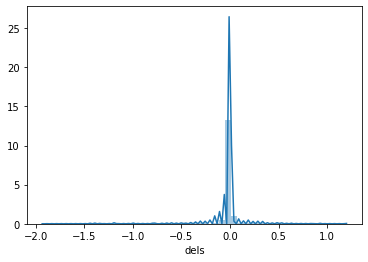

In [110]:
sns.distplot(bands['dels'])

In [115]:
low_genes = pd.merge(genes, dups_low[['name','chr','note','dups','dels']], how='inner', on=['name','chr'])

In [116]:
low_values = low_genes[['gene_id','dels']]
low_values['dels'] = -low_values['dels']
low_values.to_clipboard(sep='\t', index=False, header=False)

/Users/bogao/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [97]:
low_genes

,gene_id,name,chr,start,end,symbol,note,dups,dels
0,ENSG00000110514,p11.2,11,47269161,47330031,MADD,gneg,0.0,3.337764
1,ENSG00000134574,p11.2,11,47214465,47239240,DDB2,gneg,0.0,3.337764
2,ENSG00000149084,p11.2,11,43680680,43856617,HSD17B12,gneg,0.0,3.337764
3,ENSG00000166199,p11.2,11,43880811,43920274,ALKBH3,gneg,0.0,3.337764
4,ENSG00000187479,p11.2,11,43925342,43943878,C11orf96,gneg,0.0,3.337764
...,...,...,...,...,...,...,...,...,...
452,ENSG00000114391,q12.3,3,101681091,101686718,RPL24,gneg,0.0,1.152261
453,ENSG00000182504,q12.3,3,101724593,101770562,CEP97,gneg,0.0,1.152261
454,ENSG00000144802,q12.3,3,101827991,101861022,NFKBIZ,gneg,0.0,1.152261
455,ENSG00000144815,q12.3,3,101779202,101828231,NXPE3,gneg,0.0,1.152261


In [119]:
sk_idx = np.array([ 608,  609,  610,  611,  612,  613,  614,  615,  616,  617,  618,
        619,  620,  621,  622,  623,  624,  625,  626,  627,  628,  629,
        630,  631,  632,  633,  634,  635,  636,  637,  638,  639,  640,
        641,  642,  643,  644,  645,  646,  647,  648,  649,  650,  651,
        652,  653,  654,  655,  656,  657,  658,  659,  660,  661,  662,
        663,  692,  693,  694,  695,  696,  697,  698,  699,  700,  701,
        702,  703,  704,  781,  782,  783,  784,  785,  786,  787,  788,
        789,  790,  791,  792,  793,  794,  865,  866,  867,  868,  869,
        870,  871,  872,  873,  874,  875,  876,  877,  878,  879, 2589,
       2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600,
       2601, 2602, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 3427, 3428,
       3429, 3430, 3431, 3432, 3433, 3434, 3435, 3532, 3533, 3534, 3535,
       3536, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716,
       3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727,
       3728, 3729, 3730, 3731, 3732, 3733, 3734, 3735, 3736, 3737, 3738,
       3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749,
       3750, 3751, 3752, 3753, 3754, 3755, 5363, 5364, 5365, 5366, 5367,
       5368, 5369, 5370, 5371, 5372, 5373, 5374, 5375, 5376, 5377, 5378,
       5379, 5380, 5381, 5382, 5383, 5384, 5385, 5386, 5387, 5388, 5389,
       5390, 5391, 5392, 5602, 5603, 5604, 5605, 5606, 5607, 5608, 5609,
       5610, 5611, 5612, 5613, 5614, 5615, 5616, 5617, 5618, 5619, 5620,
       5621, 5622, 5623, 5624, 5625, 5626, 5627, 5628, 5629, 5630, 5631,
       5632, 5633, 5634, 5635, 5636, 5637, 5638, 5639, 5640, 5641, 5642,
       5643, 5644, 5645, 5646, 5647, 5821, 5822, 5823, 5824, 5825, 5826,
       5827, 5828, 5829, 5830, 5831, 5832, 5833, 5834, 5835, 5836, 6104,
       6105, 6106, 6107, 6108, 7388, 7389, 7390, 7411, 7412, 7413, 7414,
       7415, 7416, 7417, 7418, 7419, 7420, 7421, 7422, 7423, 7424, 7425,
       7426, 7427, 7428, 7429, 7430, 7431, 7432, 7433, 7434, 7435, 7436,
       7437, 7438, 7439, 7440, 7441, 7442, 7443, 7444, 7445, 7446, 7447,
       7448, 7449, 7450, 7451, 7452, 7453, 7454, 7455, 7456, 7457, 7458,
       7459, 7460, 7461, 7462, 7463, 7596, 7597, 7598, 7599, 7600, 7601,
       7602, 7603, 7604, 7605, 7606, 7607, 7608, 7609, 7610, 7611, 7612,
       7613, 7614, 7615, 7616, 9294, 9295, 9296, 9297, 9298, 9299, 9300,
       9301, 9302, 9303, 9304, 9305, 9306, 9307, 9308, 9309, 9310, 9311,
       9312, 9313, 9314, 9315, 9316, 9317, 9318, 9319, 9320, 9321, 9322,
       9323, 9324, 9325, 9326, 9327, 9328, 9329, 9330, 9331, 9332, 9333,
       9334, 9335, 9336, 9337, 9338, 9339, 9340, 9341, 9342, 9343, 9344,
       9345, 9346, 9347, 9348, 9349, 9500, 9501, 9502, 9503, 9504, 9505,
       9506, 9507, 9508, 9509, 9510, 9511, 9512, 9545, 9546, 9547, 9548,
       9549, 9550, 9551, 9552, 9553, 9554, 9555, 9556])


In [121]:
sk_anlysis = np.zeros(input_size)
for i in sk_idx:
    sk_anlysis = np.add(sk_anlysis, analysis[i])
sk_anlysis.shape

(1622,)

In [122]:
len(sk_idx)

437

In [123]:
sk_ave = sk_anlysis / len(sk_idx)

In [124]:
sk_ave

array([ 0.        ,  0.21155874,  0.09382618, ...,  0.0241074 ,
       -0.06330221,  0.        ])

In [125]:
bands = bands.assign(dups=sk_ave[:811])
bands = bands.assign(dels=weight[811:])

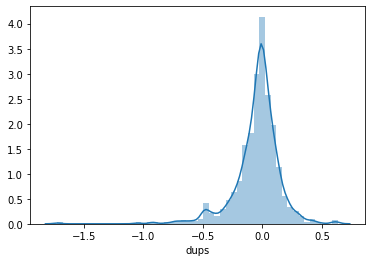

In [126]:
sns.distplot(bands['dups'])

In [150]:
dups_high = bands[bands['dups']>0.1]

In [130]:
dups_high

,chro,start,end,name,note,chr,dups,dels
49,chr1,111200000,115500000,p13.2,gpos50,1,0.340673,0.000000
50,chr1,46300000,50200000,p33,gpos75,1,0.422836,0.000000
60,chr1,58500000,60800000,p32.1,gneg,1,0.415069,0.000000
77,chr2,52600000,54700000,p16.2,gneg,2,0.371807,0.000000
147,chr3,179300000,183000000,q26.33,gpos75,3,0.343613,0.011096
279,chr6,58500000,59800000,p11.1,acen,6,0.306462,-0.031883
283,chr6,100000000,105000000,q16.3,gpos100,6,0.484329,-0.001184
286,chr6,117900000,118100000,q22.2,gneg,6,0.319468,0.002662
332,chr7,107800000,115000000,q31.1,gpos75,7,0.633112,0.000000
334,chr7,115000000,117700000,q31.2,gneg,7,0.603317,0.000000


In [151]:
high_genes = pd.merge(genes, dups_high[['name','chr','note','dups','dels']], how='inner', on=['name','chr'])

In [132]:
high_values = high_genes[['gene_id','dups']]

,gene_id,name,chr,start,end,symbol,note,dups,dels
0,ENSG00000162600,p32.1,1,58415384,58546802,OMA1,gneg,0.415069,0.0
1,ENSG00000173406,p32.1,1,56994778,58546734,DAB1,gneg,0.415069,0.0
2,ENSG00000184292,p32.1,1,58575433,58577252,TACSTD2,gneg,0.415069,0.0
3,ENSG00000162601,p32.1,1,58643440,58700077,MYSM1,gneg,0.415069,0.0
4,ENSG00000177606,p32.1,1,58780791,58784047,JUN,gneg,0.415069,0.0
...,...,...,...,...,...,...,...,...,...
241,ENSG00000042832,q24.22,8,132866958,133134903,TG,gneg,0.313319,0.0
242,ENSG00000104415,q24.22,8,133191039,133231690,CCN4,gneg,0.313319,0.0
243,ENSG00000104419,q24.22,8,133237171,133302022,NDRG1,gneg,0.313319,0.0
244,ENSG00000008513,q24.22,8,133454848,133571940,ST3GAL1,gneg,0.313319,0.0


In [152]:
high_genes[['gene_id','dups']].to_clipboard(sep='\t', index=False, header=False)

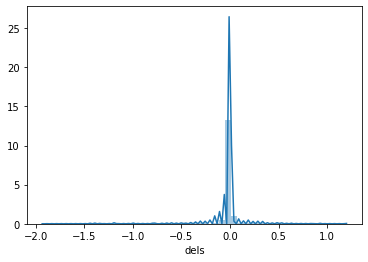

In [134]:
sns.distplot(bands['dels'])

In [153]:
dups_low =  bands[bands['dels'] > 0.1]
dups_low

,chro,start,end,name,note,chr,dups,dels
143,chr3,161000000,167900000,q26.1,gpos100,3,0.102936,0.504530
336,chr7,132900000,138500000,q33,gpos50,7,0.059446,0.278626
376,chr8,72000000,74600000,q21.11,gpos100,8,-0.259245,0.294778
377,chr8,97900000,100500000,q22.2,gpos25,8,-0.210961,0.123228
380,chr8,138900000,145138636,q24.3,gneg,8,-0.035748,0.188744
384,chr8,118300000,121500000,q24.12,gpos50,8,-0.302328,0.292878
463,chr10,91100000,92300000,q23.32,gneg,10,-0.066807,0.321222
479,chr10,3000000,3800000,p15.2,gpos25,10,-0.034584,0.533989
507,chr11,51000000,53400000,p11.11,acen,11,-0.109819,0.241343
509,chr11,43400000,48800000,p11.2,gneg,11,-0.015522,0.848635


In [154]:
low_genes = pd.merge(genes, dups_low[['name','chr','note','dups','dels']], how='inner', on=['name','chr'])

In [155]:
low_values = low_genes[['gene_id','dels']]
low_values['dels'] = -low_values['dels']
low_values.to_clipboard(sep='\t', index=False, header=False)

/Users/bogao/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [139]:
low_genes

,gene_id,name,chr,start,end,symbol,note,dups,dels
0,ENSG00000107959,p15.2,10,3137728,3172841,PITRM1,gpos25,-0.034584,0.533989
1,ENSG00000067057,p15.2,10,3066333,3137718,PFKP,gpos25,-0.034584,0.533989
2,ENSG00000067082,p15.2,10,3775996,3785281,KLF6,gpos25,-0.034584,0.533989
3,ENSG00000198060,q23.32,10,92291167,92353964,MARCH5,gneg,-0.066807,0.321222
4,ENSG00000180628,q23.32,10,91163012,91284337,PCGF5,gneg,-0.066807,0.321222
...,...,...,...,...,...,...,...,...,...
228,ENSG00000155792,q24.12,8,119873717,120050918,DEPTOR,gpos50,-0.302328,0.292878
229,ENSG00000187955,q24.12,8,120059780,120373573,COL14A1,gpos50,-0.302328,0.292878
230,ENSG00000172164,q24.12,8,120535745,120813273,SNTB1,gpos50,-0.302328,0.292878
231,ENSG00000172167,q24.12,8,120445400,120542133,MTBP,gpos50,-0.302328,0.292878


In [147]:
low_values

,gene_id,dels
0,ENSG00000116741,-0.027828
1,ENSG00000127074,-0.027828
2,ENSG00000150681,-0.027828
3,ENSG00000253148,-0.027828
4,ENSG00000090104,-0.027828
...,...,...
3147,ENSG00000242616,-0.028115
3148,ENSG00000059769,-0.028115
3149,ENSG00000244115,-0.028115
3150,ENSG00000165181,-0.028115
